# GNN with Pytorch Geometric
In this notebook, an existing dataloader of PyG, the TUDataset, will be adapted to work with our files. Afterwards, the loaded data will be tested with a simple graph neural network (GNN). </br>
Note that, due to problems with the local environment and pytorch, this notebook was tested and developed to work in google colab. 

## Install and import necesarry pytorch packages

In [ ]:
# Install required packages.
import os
import torch
os.environ['TORCH'] = torch.__version__
print(torch.__version__)

!pip install -q torch-scatter -f https://data.pyg.org/whl/torch-${TORCH}.html
!pip install -q torch-sparse -f https://data.pyg.org/whl/torch-${TORCH}.html
!pip install -q git+https://github.com/pyg-team/pytorch_geometric.git

1.12.1+cu113
     |████████████████████████████████| 8.9 MB 2.9 MB/s 
     |████████████████████████████████| 3.5 MB 2.9 MB/s 
     |████████████████████████████████| 280 kB 4.9 MB/s 


In [ ]:
import glob
import os
import os.path as osp

import numpy as np
import torch
import torch.nn.functional as F
from torch_sparse import coalesce
import torch_geometric
from torch_geometric.data import Data
from torch_geometric.io import read_txt_array
from torch_geometric.utils import remove_self_loops
from torch_geometric.data import InMemoryDataset, download_url, extract_zip
from torch_geometric.loader import DataLoader
from torch.nn import Linear
import torch.nn.functional as F
from torch_geometric.nn import GCNConv
from torch_geometric.nn import global_mean_pool

from IPython.display import Javascript

import os
import os.path as osp
import shutil
from typing import Callable, List, Optional

import networkx as nx
import random

## Adapt the TUDataset dataloader to load own data
The structure of the TUDataset dataloader code is useful, but some changes are made to it in order to be able to work with own datafiles. Additionally, the code is completely commented to improve readability in comparison to the almost uncommented original. <br>
Original code: https://pytorch-geometric.readthedocs.io/en/latest/_modules/torch_geometric/datasets/tu_dataset.html

### read_data function
First, the read_data function will be determined, which is used by the dataloader to read the data from the given .txt file.

In [ ]:
def read_data(folder, prefix):
  """
  This function reads the given text files and depending on the name,
  it will be processed accordingly. This code is based on the read_tu_data
  code from torch_geometric.io and adapted to work with non-TU datasets.
  """
  # Load the .txt files from the specified folder
  files = glob.glob(osp.join(folder, f'{prefix}_*.txt'))
  # For every file in the folder, put the name in a list
  names = [f.split(os.sep)[-1][len(prefix) + 1:-4] for f in files]

  # Read the adjacency matrix .txt file
  edge_index = read_file(folder, prefix, 'A', torch.long).t() - 1
  # Read the graph ID .txt file
  batch = read_file(folder, prefix, 'graph_indicator', torch.long) - 1

  # Read the node atrribute .txt file (if it's in the folder)
  node_attributes = torch.empty((batch.size(0), 0))
  if 'node_attributes' in names:
    node_attributes = read_file(folder, prefix, 'node_attributes')

    # Read the node labels .txt file (if it's in the folder)
    node_labels = torch.empty((batch.size(0), 0))
    if 'node_labels' in names:
        node_labels = read_file(folder, prefix, 'node_labels', torch.long)
        # If the dimension is 1, unsqueeze the tensor to seperate the labels
        if node_labels.dim() == 1:
            node_labels = node_labels.unsqueeze(-1)
        # If applicable, downsize 
        node_labels = node_labels - node_labels.min(dim=0)[0]
        # Create individual tensors
        node_labels = node_labels.unbind(dim=-1)
        # One-hot encode the labels
        node_labels = [F.one_hot(x, num_classes=-1) for x in node_labels]
        # Change to float
        node_labels = torch.cat(node_labels, dim=-1).to(torch.float)

    # Read the edge attributes .txt file (if it's in the folder)
    edge_attributes = torch.empty((edge_index.size(1), 0))
    if 'edge_attributes' in names:
        edge_attributes = read_file(folder, prefix, 'edge_attributes')

    # Read the edge labels .txt file (if it's in the folder)
    edge_labels = torch.empty((edge_index.size(1), 0))
    if 'edge_labels' in names:
        edge_labels = read_file(folder, prefix, 'edge_labels', torch.long)
        # If the dimension is 1, unsqueeze the tensor to seperate the labels
        if edge_labels.dim() == 1:
            edge_labels = edge_labels.unsqueeze(-1)
        # If applicable, downsize
        edge_labels = edge_labels - edge_labels.min(dim=0)[0]
        # Create individual tensors
        edge_labels = edge_labels.unbind(dim=-1)
        # One-hot encode the labels
        edge_labels = [F.one_hot(e, num_classes=-1) for e in edge_labels]
        # Change to float
        edge_labels = torch.cat(edge_labels, dim=-1).to(torch.float)

    # Create the x variable using the node attributes and labels
    x = cat([node_attributes, node_labels])
    # Create the edge_attr variable by using the egde attributes and labels
    edge_attr = cat([edge_attributes, edge_labels])

    # Set the y variable to None
    y = None
    # If there are graph attributes or graph labels, this will be used as the y variable
    if 'graph_attributes' in names:  # Regression problem.
        y = read_file(folder, prefix, 'graph_attributes')
    elif 'graph_labels' in names:  # Classification problem.
        y = read_file(folder, prefix, 'graph_labels', torch.long)
        _, y = y.unique(sorted=True, return_inverse=True)

    # Count the number of nodes
    num_nodes = edge_index.max().item() + 1 if x is None else x.size(0)
    # Remove the self loops
    edge_index, edge_attr = remove_self_loops(edge_index, edge_attr)
    # Coalesce the edge index and attribute
    edge_index, edge_attr = coalesce(edge_index, edge_attr, num_nodes,
                                      num_nodes)

    # Create the dataset
    data = Data(x=x, edge_index=edge_index, edge_attr=edge_attr, y=y)
    # Create the slices the indicate the separations between graphs
    data, slices = split(data, batch)

    # Calculate sizes
    sizes = {
        'num_node_attributes': node_attributes.size(-1),
        'num_node_labels': node_labels.size(-1),
        'num_edge_attributes': edge_attributes.size(-1),
        'num_edge_labels': edge_labels.size(-1),
    }

    return data, slices, sizes


def read_file(folder, prefix, name, dtype=None):
    """
    Read a file in the specified path, return as specified type
    """
    path = osp.join(folder, f'{prefix}_{name}.txt')
    return read_txt_array(path, sep=',', dtype=dtype)


def cat(seq):
    """
    Combine the given input in one tensor
    """
    seq = [item for item in seq if item is not None]
    seq = [item for item in seq if item.numel() > 0]
    seq = [item.unsqueeze(-1) if item.dim() == 1 else item for item in seq]
    return torch.cat(seq, dim=-1) if len(seq) > 0 else None


def split(data, batch):
    """
    Determines the slices of the data based on the given batch indicator
    """
    node_slice = torch.cumsum(torch.from_numpy(np.bincount(batch)), 0)
    node_slice = torch.cat([torch.tensor([0]), node_slice])

    row, _ = data.edge_index
    edge_slice = torch.cumsum(torch.from_numpy(np.bincount(batch[row])), 0)
    edge_slice = torch.cat([torch.tensor([0]), edge_slice])
 
    # Edge indices should start at zero for every graph.
    data.edge_index -= node_slice[batch[row]].unsqueeze(0)

    slices = {'edge_index': edge_slice}
    if data.x is not None:
        slices['x'] = node_slice
    else:
        # Imitate `collate` functionality:
        data._num_nodes = torch.bincount(batch).tolist()
        data.num_nodes = batch.numel()
    if data.edge_attr is not None:
        slices['edge_attr'] = edge_slice
    if data.y is not None:
        if data.y.size(0) == batch.size(0):
            slices['y'] = node_slice
        else:
            btch = batch.sort().values # Sort values
            slices['y'] = torch.arange(0, btch[-1] + 2, dtype=torch.long)

    return data, slices

### LoadData
The dataloader, to which callable properties are added

In [ ]:
class LoadData(InMemoryDataset):
  """
  Loads the data of the different .txt files, being:
    Adjacency matrix: root + _A
    Graph ID: root + _graph_indicator
    Edge labels: root + _edge_labels
    Node labels: root + _node_labels
    Node attributes: root + _node_attributes
  This is transformed to a workable data format for pytorch geometric

  Note that it has to be specified if the node and edge attributes are used, as
  well as the transform, pre-transform and pre-filter, the default is not using 
  them
  """
  def __init__(self, root: str, name: str,
              transform: Optional[Callable] = None,
              pre_transform: Optional[Callable] = None,
              pre_filter: Optional[Callable] = None,
              use_node_attr: bool = False, use_edge_attr: bool = False,
              cleaned: bool = False):
    self.name = name
    self.cleaned = cleaned
    super().__init__(root, transform, pre_transform, pre_filter)

    # If there is already a processed file available, this is loaded if not, created
    out = torch.load(self.processed_paths[0])
    if not isinstance(out, tuple) and len(out) != 3:
        raise RuntimeError(
            "The 'data' object was created by an older version of PyG. "
            "If this error occurred while loading an already existing "
            "dataset, remove the 'processed/' directory in the dataset's "
            "root folder and try again.")
    self.data, self.slices, self.sizes = out

    # Set number of node attributes
    if self.data.x is not None and not use_node_attr:
        num_node_attributes = self.num_node_attributes
        self.data.x = self.data.x[:, num_node_attributes:]
    
    # Set number of edge attributes
    if self.data.edge_attr is not None and not use_edge_attr:
        num_edge_attributes = self.num_edge_attributes
        self.data.edge_attr = self.data.edge_attr[:, num_edge_attributes:]

# Below, the different properties are determined
  @property
  def raw_dir(self) -> str:
      name = f'raw{"_cleaned" if self.cleaned else ""}'
      return osp.join(self.root, self.name, name)

  @property
  def processed_dir(self) -> str:
      name = f'processed{"_cleaned" if self.cleaned else ""}'
      return osp.join(self.root, self.name, name)

  @property
  def num_node_labels(self) -> int:
      return self.sizes['num_node_labels']

  @property
  def num_node_attributes(self) -> int:
      return self.sizes['num_node_attributes']

  @property
  def num_edge_labels(self) -> int:
      return self.sizes['num_edge_labels']

  @property
  def num_edge_attributes(self) -> int:
      return self.sizes['num_edge_attributes']

  @property
  def raw_file_names(self) -> List[str]:
      names = ['A', 'graph_indicator']
      return [f'{self.name}_{name}.txt' for name in names]

  @property
  def processed_file_names(self) -> str:
      return 'data.pt'


  def process(self):
    # Read the data using the determined read_data function
      self.data, self.slices, sizes = read_data(self.raw_dir, self.name) 

    # Checks if filters are set
      if self.pre_filter is not None or self.pre_transform is not None:
          data_list = [self.get(idx) for idx in range(len(self))]

          if self.pre_filter is not None:
              data_list = [d for d in data_list if self.pre_filter(d)]

          if self.pre_transform is not None:
              data_list = [self.pre_transform(d) for d in data_list]

          self.data, self.slices = self.collate(data_list)
          self._data_list = None  # Reset cache.

    # Save the created files
      torch.save((self.data, self.slices, sizes), self.processed_paths[0])

  def __repr__(self) -> str:
    return f'{self.name}({len(self)})'

## Use the data loader
Load the chosen files with the LoadData class. This dataset consists of only molecules, no reaction nodes, the exact description of these files can be found in notebook 2.1

In [ ]:
dataset = LoadData(root='2-Pytorch geometric data/TU', name='MOLfiles', use_node_attr = True, use_edge_attr = False)
dataset

Processing...
Done!


MOLfiles(31)

Show the features of the dataset

In [ ]:
print(f'Dataset: {dataset}:')
print('======================')
print(f'Number of graphs: {len(dataset)}')
print(f'Number of features: {dataset.num_features}')
print(f'Number of classes: {dataset.num_classes}')

Dataset: MOLfiles(31):
Number of graphs: 31
Number of features: 17
Number of classes: 2


Show an example graph

In [ ]:
data = dataset[1]  # Get the first graph object.

print(data)
print('==============================================================')

# Print some statistics about the graph.
print(f'Number of nodes: {data.num_nodes}')
print(f'Number of edges: {data.num_edges}')
print(f'Average node degree: {data.num_edges / data.num_nodes:.2f}')
print(f'Has isolated nodes: {data.has_isolated_nodes()}')
print(f'Has self-loops: {data.has_self_loops()}')
print(f'Is undirected: {data.is_undirected()}')

Data(edge_index=[2, 2], x=[2, 17], edge_attr=[2, 3], y=[1])
Number of nodes: 2
Number of edges: 2
Average node degree: 1.00
Has isolated nodes: False
Has self-loops: False
Is undirected: True


Print a random molecule from the dataset as test

None
[{'edge_index': tensor([[0, 0, 1, 1, 2, 2, 2, 3, 3, 3, 4, 4, 5, 5, 6, 6, 7, 8],
        [4, 5, 5, 6, 3, 4, 6, 2, 7, 8, 0, 2, 0, 1, 1, 2, 3, 3]]), 'x': tensor([[ 3.0000e+00,  3.4700e-02,  9.1516e+00, -9.0662e+00,  0.0000e+00,
          0.0000e+00,  0.0000e+00,  1.0000e+00,  0.0000e+00,  0.0000e+00,
          0.0000e+00,  0.0000e+00,  1.0000e+00,  0.0000e+00,  1.0000e+00,
          1.0000e+00,  0.0000e+00],
        [ 3.0000e+00,  2.8000e-03,  9.1516e+00, -9.0662e+00,  0.0000e+00,
          0.0000e+00,  1.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
          0.0000e+00,  0.0000e+00,  1.0000e+00,  0.0000e+00,  1.0000e+00,
          1.0000e+00,  0.0000e+00],
        [ 3.0000e+00,  2.8000e-03,  9.1516e+00, -9.0662e+00,  0.0000e+00,
          0.0000e+00,  1.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
          0.0000e+00,  0.0000e+00,  1.0000e+00,  0.0000e+00,  1.0000e+00,
          1.0000e+00,  0.0000e+00],
        [ 3.0000e+00,  1.0000e-04,  9.1516e+00, -9.0662e+00,  0.0000e+

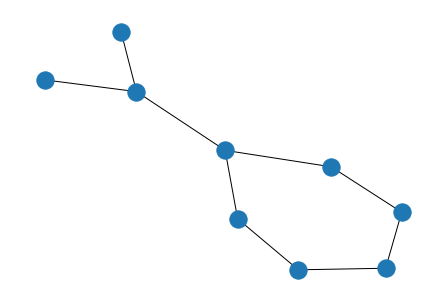

In [ ]:
# Get a random number to select a random molecule
n = random.randint(0,len(dataset)-1)
data = dataset[n]

# Draw the molecule 
g = torch_geometric.utils.to_networkx(data, to_undirected=True)
print(nx.draw(g))

# Print molecule features
print(data.edge_stores)

## Graph Neural Network
In this part, we will test the loaded graph dataset by creating a basic GNN. The code below is broadly based on a tutorial of PyG: https://colab.research.google.com/drive/1I8a0DfQ3fI7Njc62__mVXUlcAleUclnb?usp=sharing#scrollTo=HvhgQoO8Svw4.</br> The goal of this GNN is to classify whether molecules that are part of a reaction or not.</br>
### Train/test split
First, the data will be split in a training and test set.

In [ ]:
# Set a seed
torch.manual_seed(1)

# Call the shuffle function of the dataset
dataset = dataset.shuffle()

# Split the shuffled dataset in a train and test part
train_dataset = dataset[:22]
test_dataset = dataset[22:]

# Print the number of graphs per dataset
print(f'Number of training graphs: {len(train_dataset)}')
print(f'Number of test graphs: {len(test_dataset)}')

Number of training graphs: 22
Number of test graphs: 9


In [ ]:
# Print the y values of the train dataset 
for n in range(len(train_dataset)):
  print(train_dataset[n].y)

tensor([1])
tensor([0])
tensor([1])
tensor([0])
tensor([0])
tensor([1])
tensor([1])
tensor([1])
tensor([1])
tensor([1])
tensor([1])
tensor([1])
tensor([1])
tensor([1])
tensor([1])
tensor([1])
tensor([0])
tensor([1])
tensor([1])
tensor([1])
tensor([1])
tensor([1])


In [ ]:
# Print the y values of the test dataset
for n in range(len(test_dataset)):
  print(test_dataset[n].y)

tensor([1])
tensor([1])
tensor([0])
tensor([1])
tensor([1])
tensor([1])
tensor([1])
tensor([1])
tensor([1])


In [ ]:
# Load the train and test dataset in batches
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=True)

# Show output of number of batches
for step, data in enumerate(train_loader):
    print(f'Step {step + 1}:')
    print('=======')
    print(f'Number of graphs in the current batch: {data.num_graphs}')
    print(data)
    print()

Step 1:
Number of graphs in the current batch: 22
DataBatch(edge_index=[2, 324], x=[171, 17], edge_attr=[324, 3], y=[22], batch=[171], ptr=[23])



### Create the GNN model

In [ ]:
# Create the GCN class
class GCN(torch.nn.Module):
    # Define the hidden channels
    def __init__(self, hidden_channels):
        super(GCN, self).__init__()
        torch.manual_seed(12345)
        self.conv1 = GCNConv(dataset.num_node_features, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, hidden_channels)
        self.conv3 = GCNConv(hidden_channels, hidden_channels)
        self.lin = Linear(hidden_channels, dataset.num_classes)

    def forward(self, x, edge_index, batch):
        # 1. Obtain node embeddings 
        x = self.conv1(x, edge_index)
        x = x.relu()
        x = self.conv2(x, edge_index)
        x = x.relu()
        x = self.conv3(x, edge_index)

        # 2. Readout layer
        x = global_mean_pool(x, batch)  # [batch_size, hidden_channels]

        # 3. Apply a final classifier
        x = F.dropout(x, p=0.5, training=self.training)
        x = self.lin(x)
        
        return x

model = GCN(hidden_channels=64)
print(model)

GCN(
  (conv1): GCNConv(17, 64)
  (conv2): GCNConv(64, 64)
  (conv3): GCNConv(64, 64)
  (lin): Linear(in_features=64, out_features=2, bias=True)
)


### Run the GNN

In [ ]:
# Set display
display(Javascript('''google.colab.output.setIframeHeight(0, true, {maxHeight: 300})'''))

# Call the model
model = GCN(hidden_channels=64)

# Set optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

# Set criterion
criterion = torch.nn.CrossEntropyLoss()

# Define the train function
def train():
    model.train()

    for data in train_loader:  # Iterate in batches over the training dataset.
         out = model(data.x, data.edge_index, data.batch)  # Perform a single forward pass.
         loss = criterion(out, data.y)  # Compute the loss.
         loss.backward()  # Derive gradients.
         optimizer.step()  # Update parameters based on gradients.
         optimizer.zero_grad()  # Clear gradients.

# Define the test function
def test(loader):
     model.eval()

     correct = 0
     for data in loader:  # Iterate in batches over the training/test dataset.
         out = model(data.x, data.edge_index, data.batch)  
         pred = out.argmax(dim=1)  # Use the class with highest probability.
         print(pred)
         correct += int((pred == data.y).sum())  # Check against ground-truth labels.
     return correct / len(loader.dataset)  # Derive ratio of correct predictions.

# Set the amount of epochs and run the GNN
n_epochs = 150
for epoch in range(1, n_epochs):
    train()
    # Get train and test accuracy
    train_acc = test(train_loader)
    test_acc = test(test_loader)
    # Print output
    print(f'Epoch: {epoch:03d}, Train Acc: {train_acc:.4f}, Test Acc: {test_acc:.4f}')

<IPython.core.display.Javascript object>

tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])
tensor([1, 1, 1, 1, 1, 1, 1, 1, 1])
Epoch: 001, Train Acc: 0.8182, Test Acc: 0.8889
tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])
tensor([1, 1, 1, 1, 1, 1, 1, 1, 1])
Epoch: 002, Train Acc: 0.8182, Test Acc: 0.8889
tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])
tensor([1, 1, 1, 1, 1, 1, 1, 1, 1])
Epoch: 003, Train Acc: 0.8182, Test Acc: 0.8889
tensor([1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1])
tensor([1, 1, 1, 0, 1, 1, 1, 1, 1])
Epoch: 004, Train Acc: 0.9091, Test Acc: 1.0000
tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])
tensor([1, 1, 1, 1, 1, 1, 1, 1, 1])
Epoch: 005, Train Acc: 0.8182, Test Acc: 0.8889
tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])
tensor([1, 1, 1, 1, 1, 1, 1, 1, 1])
Epoch: 006, Train Acc: 0.8182, Test Acc: 0.8889
tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,